<a href="https://colab.research.google.com/github/tony-pitchblack/finrl-dt/blob/custom-backtesting/finrl_dt_replicate_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installs

In [1]:
!pip install -q yfinance==0.2.50

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 2.0 MB/s eta 0:00:00


In [2]:
%%capture
!pip install stable-baselines3
!pip install finrl
!pip install alpaca_trade_api
!pip install exchange_calendars
!pip install stockstats
!pip install wrds

In [3]:
import numpy as np

if np.__version__ != '1.26.4':
    !pip install -q numpy==1.26.4 --force-reinstall

In [4]:
%%capture
import pandas as pd

if pd.__version__ != '2.2.2':
    !pip install -q pandas==2.2.2 --force-reinstall

In [5]:
# %load_ext autoreload
# %autoreload 2

# Imports

In [6]:
import pandas as pd

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
import os
from pathlib import Path
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
os.environ["WANDB_API_KEY"] = "aee284a72205e2d6787bd3ce266c5b9aefefa42c"

PROJECT = 'finrl-dt-replicate'
ENTITY = "overfit1010"

# General funcs

In [9]:
#@title YahooDownloader

"""Contains methods and classes to collect data from
Yahoo Finance API
"""

from __future__ import annotations

import pandas as pd
import yfinance as yf


class YahooDownloader:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from neofinrl_config.py)
        end_date : str
            end date of the data (modified from neofinrl_config.py)
        ticker_list : list
            a list of stock tickers (modified from neofinrl_config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API

    """

    def __init__(self, start_date: str, end_date: str, ticker_list: list):
        self.start_date = start_date
        self.end_date = end_date
        self.ticker_list = ticker_list

    def fetch_data(self, proxy=None) -> pd.DataFrame:
        """Fetches data from Yahoo API
        Parameters
        ----------

        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """
        # Download and save the data in a pandas DataFrame:
        data_df = pd.DataFrame()
        num_failures = 0
        for tic in self.ticker_list:
            temp_df = yf.download(
                tic, start=self.start_date, end=self.end_date, proxy=proxy
            )
            temp_df["tic"] = tic
            if len(temp_df) > 0:
                # data_df = data_df.append(temp_df)
                data_df = pd.concat([data_df, temp_df], axis=0)
            else:
                num_failures += 1
        if num_failures == len(self.ticker_list):
            raise ValueError("no data is fetched.")
        # reset the index, we want to use numbers as index instead of dates
        data_df = data_df.reset_index()

        try:
            # Convert wide to long format
            # print(f"DATA COLS: {data_df.columns}")
            data_df = data_df.sort_index(axis=1).set_index(['Date']).drop(columns=['tic']).stack(level='Ticker', future_stack=True)
            data_df.reset_index(inplace=True)
            data_df.columns.name = ''

            # convert the column names to standardized names
            data_df.rename(columns={'Ticker': 'Tic', 'Adj Close': 'Adjcp'}, inplace=True)
            data_df.rename(columns={col: col.lower() for col in data_df.columns}, inplace=True)

            columns = [
                "date",
                "tic",
                "open",
                "high",
                "low",
                "close",
                "adjcp",
                "volume",
            ]

            data_df = data_df[columns]
            # use adjusted close price instead of close price
            data_df["close"] = data_df["adjcp"]
            # drop the adjusted close price column
            data_df = data_df.drop(labels="adjcp", axis=1)

        except NotImplementedError:
            print("the features are not supported currently")

        # create day of the week column (monday = 0)
        data_df["day"] = data_df["date"].dt.dayofweek
        # convert date to standard string format, easy to filter
        data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
        # drop missing data
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        # print("Display DataFrame: ", data_df.head())

        data_df = data_df.sort_values(by=["date", "tic"]).reset_index(drop=True)

        return data_df

    def select_equal_rows_stock(self, df):
        df_check = df.tic.value_counts()
        df_check = pd.DataFrame(df_check).reset_index()
        df_check.columns = ["tic", "counts"]
        mean_df = df_check.counts.mean()
        equal_list = list(df.tic.value_counts() >= mean_df)
        names = df.tic.value_counts().index
        select_stocks_list = list(names[equal_list])
        df = df[df.tic.isin(select_stocks_list)]
        return df


In [10]:
#@title fix_daily_index

def make_daily_index(data_df, date_column='date', new_index_name='date_index'):
    # Get unique dates and create a mapping to daily indices
    total_dates = data_df[date_column].unique()
    date_to_index = {date: idx for idx, date in enumerate(sorted(total_dates))}
    return data_df[date_column].map(date_to_index)

def set_daily_index(data_df, date_column='date', new_index_name='date_index'):
    """
    Constructs a daily index from unique dates in the specified column.

    Parameters:
        data_df (pd.DataFrame): The input DataFrame.
        date_column (str): The name of the column containing dates.
        new_index_name (str): The name for the new index.

    Returns:
        pd.DataFrame: DataFrame with a daily index.
    """

    # Map dates to daily indices and set as index
    data_df[new_index_name] = make_daily_index(data_df, date_column='date', new_index_name='date_index')

    data_df.set_index(new_index_name, inplace=True)
    data_df.index.name = ''  # Remove the index name for simplicity

    return data_df

def fix_daily_index(df):
    if df.index.name == 'date':
        df.reset_index(inplace=True)

    daily_index = make_daily_index(df, date_column='date', new_index_name='date_index')
    if (df.index.values != daily_index.values).any():

        df.index = daily_index
        df.index.name = ''

    return df

# trade = fix_daily_index(trade)
# trade.index

In [11]:
#@title get dataset name

def get_quarterly_dataset_name(prefix, train_start_date, val_start_date, test_start_date):
    get_quarter = lambda date: f'Q{(date.month - 1) // 3 + 1}'

    val_quarter = get_quarter(val_start_date)
    test_quarter = get_quarter(test_start_date)

    # Extract year and month
    train_start = f"{train_start_date.year}-{train_start_date.month:02}"
    val_start = f"{val_start_date.year}"
    test_start = f"{test_start_date.year}"

    # Construct the dataset name
    dataset_name = f"{prefix} | {train_start} | {val_start} {val_quarter} | {test_start} {test_quarter}"

    return dataset_name

def get_yearly_dataset_name(prefix, train_start, test_start, test_end):
    # Extract year and month
    train_start_str = f"{train_start.year}-{train_start.month:02}"
    test_start_str = f"{test_start.year}-{test_start.month:02}"
    test_end_str = f"{test_end.year}-{test_end.month:02}"

    # Construct the dataset name
    dataset_name = f"{prefix} | {train_start_str} | {test_start_str} | {test_end_str}"
    return dataset_name


In [12]:
#@title add_dataset

def add_dataset(stock_index_name, train_df, test_df):
    if 'datasets' not in globals():
        global datasets
        datasets = {}

    # Ensure datetime format
    if 'date' in train_df.columns:
        train_df.set_index('date', inplace=True)
    train_df.index = pd.to_datetime(train_df.index)

    if 'date' in test_df.columns:
        test_df.set_index('date', inplace=True)
    test_df.index = pd.to_datetime(test_df.index)

    train_start_date = train_df.index[0]
    test_start_date = test_df.index[0]
    test_end_date = test_df.index[-1]

    dataset_name = get_yearly_dataset_name(
        stock_index_name,
        train_start_date, test_start_date, test_end_date
    )

    train_df.reset_index(inplace=True)
    test_df.reset_index(inplace=True)

    train_df = set_daily_index(train_df)
    test_df = set_daily_index(test_df)

    ticker_list = train_df.tic.unique().tolist()

    datasets[dataset_name] = {
        'train': train_df,
        'test': test_df,
        'metadata': dict(
            stock_index_name = stock_index_name,
            train_start_date = train_start_date,
            test_start_date = test_start_date,
            test_end_date = test_end_date,
            num_tickers = len(ticker_list),
            ticker_list = ticker_list,
        )
    }

# Load data

## DATA: DOW-30 (rolling yearly windows)

In [ ]:
#@title download full data
%%capture

min_test_start_year = 2020
max_test_start_year = 2025

train_years_count = 10
test_years_count = 1.5

min_date = \
    pd.Timestamp(year=min_test_start_year, month=1, day=1) - \
    pd.Timedelta(days=int(train_years_count * 365.2425))

max_date = \
    pd.Timestamp(year=max_test_start_year, month=1, day=1) + \
    pd.Timedelta(days=int(test_years_count * 365.2425))

data_df = YahooDownloader(
    start_date=min_date,
    end_date=max_date,
    ticker_list=config_tickers.DOW_30_TICKER
).fetch_data()

data_df['date'] = pd.to_datetime(data_df['date'])

# clip max year w.r.t. to available data
max_data_date = data_df['date'].max()
max_test_start_year = min(max_test_start_year, max_data_date.year)

In [ ]:
#@title add features

from finrl.meta.preprocessor.preprocessors import FeatureEngineer

fe = FeatureEngineer(use_turbulence=True, use_vix=True)
preprocessed_data_df = fe.preprocess_data(data_df.astype({'date': str}))
preprocessed_data_df.head()

[*********************100%***********************]  1 of 1 completed

Successfully added technical indicators


Shape of DataFrame:  (3767, 8)
Successfully added vix
Successfully added turbulence index


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,7.622500,7.660714,7.585000,6.447412,493729600.0,0,0.0,6.46875,6.43722,100.0,66.666667,100.0,6.447412,6.447412,21.68,0.0
1,2010-01-04,AMGN,56.630001,57.869999,56.560001,40.915905,5277400.0,0,0.0,6.46875,6.43722,100.0,66.666667,100.0,40.915905,40.915905,21.68,0.0
2,2010-01-04,AXP,40.810001,41.099998,40.389999,32.906178,6894300.0,0,0.0,6.46875,6.43722,100.0,66.666667,100.0,32.906178,32.906178,21.68,0.0
3,2010-01-04,BA,55.720001,56.389999,54.799999,43.777542,6186700.0,0,0.0,6.46875,6.43722,100.0,66.666667,100.0,43.777542,43.777542,21.68,0.0
4,2010-01-04,CAT,57.650002,59.189999,57.509998,39.883915,7325600.0,0,0.0,6.46875,6.43722,100.0,66.666667,100.0,39.883915,39.883915,21.68,0.0


In [ ]:
#@title get_train_test_split
def get_train_test_split(data_df, train_years_count, test_years_count, test_start_year):
    test_start_date = pd.Timestamp(year=test_start_year, month=1, day=1)

    train_start_date = \
        test_start_date - \
        pd.Timedelta(days=int(train_years_count * 365.2425))

    test_end_date = \
        test_start_date + \
        pd.Timedelta(days=int(test_years_count * 365.2425))

    # Filter using the 'date' column
    train_df = data_df[(data_df['date'] >= train_start_date) & (data_df['date'] < test_start_date)]
    test_df = data_df[(data_df['date'] >= test_start_date) & (data_df['date'] < test_end_date)]

    return train_df, test_df

In [ ]:
preprocessed_data_df['date'] = pd.to_datetime(preprocessed_data_df['date'])

for test_start_year in range(min_test_start_year, max_test_start_year + 1):
    train_df, test_df = get_train_test_split(
        # data_df,
        preprocessed_data_df,

        train_years_count, test_years_count, test_start_year
    )

    add_dataset('DOW_30', train_df, test_df)

    print(f"Train start: {train_df['date'].min()}, Train end: {train_df['date'].max()}")
    print(f"Test start: {test_df['date'].min()}, Test end: {test_df['date'].max()}")
    print()

    # break

print(*list(datasets.keys()), sep='\n')

Train start: 2010-01-04 00:00:00, Train end: 2019-12-31 00:00:00
Test start: 2020-01-02 00:00:00, Test end: 2021-06-30 00:00:00

Train start: 2011-01-03 00:00:00, Train end: 2020-12-31 00:00:00
Test start: 2021-01-04 00:00:00, Test end: 2022-07-01 00:00:00

Train start: 2012-01-03 00:00:00, Train end: 2021-12-31 00:00:00
Test start: 2022-01-03 00:00:00, Test end: 2023-06-30 00:00:00

Train start: 2013-01-02 00:00:00, Train end: 2022-12-30 00:00:00
Test start: 2023-01-03 00:00:00, Test end: 2024-06-28 00:00:00

Train start: 2014-01-02 00:00:00, Train end: 2023-12-29 00:00:00
Test start: 2024-01-02 00:00:00, Test end: 2024-12-19 00:00:00

DOW_30 | 2010-01 | 2020-01 | 2021-06
DOW_30 | 2011-01 | 2021-01 | 2022-07
DOW_30 | 2012-01 | 2022-01 | 2023-06
DOW_30 | 2013-01 | 2023-01 | 2024-06
DOW_30 | 2014-01 | 2024-01 | 2024-12


## DATA: DOW-30 (quarterly train/val/test)

In [13]:
%%capture
#@title download

train_start_date = '2019-01-01'
max_test_end_date = '2020-08-01'

########################

data_df = YahooDownloader(
    start_date= pd.Timestamp(train_start_date),
    end_date= pd.Timestamp(max_test_end_date),
    ticker_list=config_tickers.DOW_30_TICKER
).fetch_data()

data_df['date'] = pd.to_datetime(data_df['date'])

In [14]:
#@title add features
from finrl.meta.preprocessor.preprocessors import FeatureEngineer

fe = FeatureEngineer(use_turbulence=True, use_vix=True)
preproc_df = fe.preprocess_data(data_df.astype({'date': str}))
preproc_df['date'] = pd.to_datetime(preproc_df['date'])
# preproc_df.head()

Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (398, 8)
Successfully added vix
Successfully added turbulence index


In [15]:
#@title generate_quarterly_date_ranges
from calendar import monthrange

min_test_start_date = '2016-01-01'

def generate_quarterly_date_ranges(train_start_date, min_test_start_date, max_test_end_date, preproc_df, return_strings=False):
    is_quarter_start = lambda date: date.month in [1, 4, 7, 10] and date.day == 1

    min_test_start_date = pd.Timestamp(min_test_start_date)
    train_start_date = pd.Timestamp(train_start_date)
    max_test_end_date = pd.Timestamp(max_test_end_date)

    assert is_quarter_start(train_start_date), f"train_start_date {train_start_date} is not a quarter start date."
    assert is_quarter_start(min_test_start_date), f"min_test_start_date {min_test_start_date} is not a quarter start date."

    assert max_test_end_date + pd.DateOffset(month=3) <= preproc_df['date'].max()
    assert train_start_date + pd.DateOffset(days=1) >= preproc_df['date'].min()

    test_start_date = min_test_start_date
    date_ranges = []
    while True:
        val_start_date = test_start_date - pd.DateOffset(months=3)
        test_end_date = test_start_date + pd.DateOffset(months=3)

        if test_end_date > max_test_end_date:
            break

        date_range = (dict(
            train_start_date = train_start_date,
            val_start_date = val_start_date,
            test_start_date = test_start_date,
            test_end_date = test_end_date,
        ))

        if return_strings:
            date_range = {k: str(v) for k, v in date_range.items()}

        date_ranges.append(date_range)

        test_start_date = test_end_date


    return date_ranges

date_ranges = generate_quarterly_date_ranges(train_start_date, min_test_start_date, max_test_end_date, preproc_df)
# date_ranges

In [16]:
def subset_date_range(df, start_date, end_date):
    df = df[(df['date'] >= start_date) & (df['date'] < end_date)]
    df = fix_daily_index(df)
    return df

quarterly_dataset = []
for date_range in date_ranges:
    train_df, val_df, test_df = (
        subset_date_range(preproc_df, date_range['train_start_date'], date_range['val_start_date']),
        subset_date_range(preproc_df, date_range['val_start_date'], date_range['test_start_date']),
        subset_date_range(preproc_df, date_range['test_start_date'], date_range['test_end_date']),
    )
    quarterly_dataset.append((train_df, val_df, test_df))

# Train SB3 models

## Init config & dataset

In [ ]:
period_idx = -1
train, val, test = quarterly_dataset[period_idx]

In [ ]:
config = {}

In [ ]:
#@title Config: dataset

# config.update(dict(
#     # dataset_name =  'DOW_30 | 2009-01 | 2020-07 | 2021-10',
#     dataset_name =  'DOW-30 (FinRL 2021) | 2009-01 | 2020-07 | 2021-10',
# ))

# dataset = datasets[config['dataset_name']]
# config.update(dataset['metadata'])
# train = dataset['train']

In [ ]:
#@title Get reference price interval

# %%capture

# REFERENCE_PRICE_END_DATE = '2024-12-21'
# REFERNCE_PRICE_WINDOW_DAYS = 30

# ref_price_start_date = pd.Timestamp(REFERENCE_PRICE_END_DATE) - pd.Timedelta(days=REFERNCE_PRICE_WINDOW_DAYS)
# ref_price_df = YahooDownloader(
#         start_date=ref_price_start_date,
#         end_date=REFERENCE_PRICE_END_DATE,
#         ticker_list=train.tic.unique().tolist(),
#         # ticker_list=config_tickers.DOW_30_TICKER
#     ).fetch_data()

In [ ]:
#@title Calculate fee percent based on average price for past N days

def cost_pct_from_avg_price(df, cost_abs, price_avg_days, verbose=False):
    df['date'] = pd.to_datetime(df['date'])
    avg_price_dict = {}
    for tic, _df in df.groupby('tic'):
        last_date = _df['date'].max()
        _df = _df[_df.date >= last_date - pd.Timedelta(days=price_avg_days)]
        avg_price = ((_df.high + _df.low) / 2).mean()
        avg_price_dict.update({tic: avg_price})

    avg_price_df = pd.DataFrame(avg_price_dict, index=[f'cost_avg']).T
    cost_pct_df = (cost_abs / avg_price_df).rename(columns={'cost_avg': 'cost_pct'})

    if verbose:
        display(avg_price_df.head())
        print()
        display(cost_pct_df.head())

    return cost_pct_df.values.flatten().tolist()

In [ ]:
# COST_ABS = 2.5
# COST_PCT = cost_pct_from_avg_price(
#     df=ref_price_df,
#     cost_abs=COST_ABS,
#     price_avg_days=REFERNCE_PRICE_WINDOW_DAYS,
#     verbose=True
# )

In [ ]:
# config.update({
#     'env_params': {
#         'initial_amount': 50000,

#         # 'cost_abs': COST_ABS,
#         # 'cost_pct': COST_PCT

#         'cost_abs': None,
#         'cost_pct': 0.001
#     }
# })


config.update({
    'initial_amount': 50000,

    # 'cost_abs': COST_ABS,
    # 'cost_pct': COST_PCT

    'cost_abs': None,
    'cost_pct': 0.001
})

config.keys()

dict_keys(['initial_amount', 'cost_abs', 'cost_pct'])

In [ ]:
#@title Init env
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

cost_pct = config['cost_pct']
if isinstance(cost_pct, list):
    assert len(cost_pct) == stock_dimension
    buy_cost_pct = sell_cost_pct = cost_pct
elif isinstance(cost_pct, (int, float)):
    buy_cost_pct = sell_cost_pct = [ config['cost_pct'] ] * stock_dimension
else:
    raise ValueError

num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": config['initial_amount'],
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_pct,
    "sell_cost_pct": sell_cost_pct,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,

    "print_verbosity": 1,
    "make_plots": True
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

Stock Dimension: 29, State Space: 291


## Init wandb

In [ ]:
# !rm -rf ./*

In [ ]:
#@title init run
import wandb
import random
import string

def generate_run_name(prefix, n=5):
    random_str = ''.join(random.choices(string.ascii_letters + string.digits, k=n))
    return f"{prefix} | {random_str}"


wandb.finish()
wandb.init(
    project=PROJECT,
    name=generate_run_name(config['dataset_name'])
)

wandb.config.update(config)

In [ ]:
#@title update_artifact

def update_artifact(folder_path, name_prefix, type):
    """
    Create or update a W&B artifact consisting of a folder.

    Args:
        run: The current W&B run.
        folder_path (str): Path to the folder to upload.
        artifact_name (str): Name of the artifact.
        artifact_type (str): Type of the artifact.
    """
    run = wandb.run
    artifact_name = f'{name_prefix}-{wandb.run.id}'

    # Create a new artifact
    artifact = wandb.Artifact(name=artifact_name, type=type)

    # Add the folder to the artifact
    artifact.add_dir(folder_path)

    # Log the artifact to W&B
    run.log_artifact(artifact)
    print(f"Artifact '{artifact_name}' has been updated and uploaded.")

In [ ]:
#@title update_model_artifacts

def update_model_artifacts():
    update_artifact(
        folder_path = RESULTS_DIR,
        name_prefix = 'results',
        type = 'results'
    )

    update_artifact(
        folder_path = TRAINED_MODEL_DIR,
        name_prefix = 'trained_models',
        type = 'trained_models'
    )

In [ ]:
#@title update_dataset_artifact

from pathlib import Path

DATASET_DIR = Path('./dataset')
os.makedirs(DATASET_DIR, exist_ok=True)

dataset = datasets[config['dataset_name']]
dataset['train'].to_csv(DATASET_DIR / 'train_data.csv')
dataset['test'].to_csv(DATASET_DIR / 'test_data.csv')

update_artifact(
    folder_path = DATASET_DIR,
    name_prefix = 'dataset',
    type = 'dataset'
)

wandb: Adding directory to artifact (./dataset)... Done. 0.1s


Artifact 'dataset-vtr6xfa3' has been updated and uploaded.


## Train FinRL models

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./results/

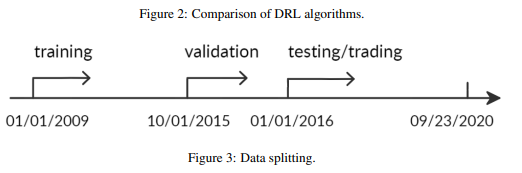

In [ ]:
#@title Define metric functions

def calculate_mdd(asset_values):
    """
    Calculate the Maximum Drawdown (MDD) of a portfolio.
    """
    running_max = asset_values.cummax()
    drawdown = (asset_values - running_max) / running_max
    mdd = drawdown.min() * 100  # Convert to percentage
    return mdd

def calculate_sharpe_ratio(asset_values, risk_free_rate=0.0):
    """
    Calculate the Sharpe Ratio of a portfolio.
    """
    # Calculate daily returns
    returns = asset_values.pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252  # Assuming 252 trading days

    if excess_returns.std() == 0:
        return 0.0
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)  # Annualized
    return sharpe_ratio

def calculate_annualized_return(asset_values):
    """
    Calculate the annualized return of a portfolio.
    """
    # Assume `asset_values` is indexed by date or trading day
    total_return = (asset_values.iloc[-1] / asset_values.iloc[0] - 1) * 100
    num_days = (asset_values.index[-1] - asset_values.index[0]).days
    annualized_return = (1 + total_return) ** (365 / num_days) - 1
    return annualized_return

In [ ]:
#@title get metrics
import wandb
from typing import List
import numpy as np

def get_account_value_metrics(account_values: List[pd.DataFrame, pd.Series, np.array]):
    """
    If DataFrame then should contain two columns - 'date' and name of algo, e.g. 'a2c'.
    """

    if isinstance(account_values, pd.DataFrame):
        assert isinstance(account_values, pd.DataFrame)
        if 'date' not in account_values.columns:
            if account_values.index.name == 'date':
                account_values.reset_index(inplace=True)
            else:
                raise ValueError("should contain 'date' column or index")
        account_values = account_values.dropna().set_index('date').iloc[:, 0]
    elif isinstance(account_values, np.ndarray):
        account_values = pd.Series(account_values)

    sharpe = calculate_sharpe_ratio(account_values)
    mdd = calculate_mdd(account_values)
    cum_ret = (account_values.iloc[-1] - account_values.iloc[0]) / account_values.iloc[0] * 100
    # num_days = (account_values.index.max() - account_values.index.min()).days
    num_days = len(account_values)
    ann_ret = ((1 + cum_ret / 100) ** (365 / num_days) - 1) * 100

    return {
            f'sharpe_ratio': sharpe,
            f'mdd': mdd,
            f'ann_return': ann_ret,
            f'cum_return': cum_ret,
        }

def get_env_metrics(env):
    end_total_asset = env.state[0] + sum(
        np.array(env.state[1 : (env.stock_dim + 1)])
        * np.array(env.state[(env.stock_dim + 1) : (env.stock_dim * 2 + 1)])
    )

    return {
        'begin_total_asset': env.asset_memory[0],
        'end_total_asset': end_total_asset,
        'total_cost': env.cost,
        'total_trades': env.trades,
    }

In [ ]:
#@title log_metrics

def log_metrics_to_wandb(metrics, model_name, split_label, step=None):
    print(f'log_metrics for {model_name}')
    assert model_name in ['a2c', 'ddpg', 'sac', 'ppo', 'td3', 'best_model', 'chosen_model']

    rename_metrics = lambda model_name: {
        f"{key}/{model_name}": value for key, value in metrics.items()
    }

    renamed_metrics = rename_metrics(model_name)
    wandb.log({split_label: renamed_metrics}, step=step)
    # wandb.run.save()

In [ ]:
#@title WandbLoggerCallback
from stable_baselines3.common.callbacks import BaseCallback
import pandas as pd
import numpy as np

class WandbLoggerCallback(BaseCallback):
    def __init__(self, model_name, split_label, verbose=0):
        super(WandbLoggerCallback, self).__init__(verbose)

        self.split_label = split_label
        self.model_name = model_name

    def _on_step(self) -> bool:
        env = self.training_env.envs[0]

        # Check if the episode is terminal
        env.terminal = env.day >= len(env.df.index.unique()) - 1
        if env.terminal:
            df_account_value = pd.DataFrame({
                self.model_name: env.asset_memory,
                'date': env.date_memory
            })

            # Compute metrics
            metrics = get_account_value_metrics(df_account_value)
            # env_metrics = get_env_metrics(env)
            # metrics.update(env_metrics)

            # Log current model metrics
            log_metrics_to_wandb(metrics, self.model_name, self.split_label)

        return True

In [ ]:
#@title Custom DRLAgent (w/ wandb callback)
from finrl.agents.stablebaselines3.models import DRLAgent, TensorboardCallback
from stable_baselines3.common.callbacks import CallbackList
import wandb

class DRLAgent(DRLAgent):
    @staticmethod
    def train_model(
        model,
        tb_log_name,
        total_timesteps=5000,
    ):
        # Ensure TensorboardCallback is always included
        tensorboard_callback = TensorboardCallback()

        # Initialize default callbacks
        wandb_logger_callback = WandbLoggerCallback(model_name=tb_log_name, split_label='train', verbose=1)

        # Combine all callbacks (always include Tensorboard, SharpeRatio, and MaxSharpeRatio by default)
        callbacks_to_use = [
            tensorboard_callback,
            wandb_logger_callback,
        ]

        # Wrap all callbacks into a CallbackList
        combined_callback = CallbackList(callbacks_to_use)

        # Train the model with the combined callbacks
        model = model.learn(
            total_timesteps=total_timesteps,
            tb_log_name=tb_log_name,
            callback=combined_callback,
        )
        return model

In [ ]:
#@title train models

check_and_make_directories([TRAINED_MODEL_DIR])

env_train, _ = e_train_gym.get_sb_env()

# Set the corresponding values to 'True' for the algorithms that you want to use

# if_using_a2c = True
if_using_a2c = False

# if_using_ddpg = True
if_using_ddpg = False

# if_using_ppo = True
if_using_ppo = False

# if_using_td3 = True
if_using_td3 = False

# if_using_sac = True
if_using_sac = False

if if_using_a2c:
    print("training A2C agent")
    agent = DRLAgent(env = env_train)
    model_a2c = agent.get_model("a2c")

    # set up logger
    tmp_path = RESULTS_DIR + '/a2c'
    !rm -rf {tmp_path}/*
    new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_a2c.set_logger(new_logger_a2c)

    trained_a2c = agent.train_model(model=model_a2c,
                                    tb_log_name='a2c',
                                    # total_timesteps=50_000,
                                    total_timesteps=3500,
                                    ) if if_using_a2c else None

    trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
    update_model_artifacts()

if if_using_ddpg:
    print("training DDPG agent")
    agent = DRLAgent(env = env_train)
    model_ddpg = agent.get_model("ddpg")

    # set up logger
    tmp_path = RESULTS_DIR + '/ddpg'
    !rm -rf {tmp_path}/*
    new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_ddpg.set_logger(new_logger_ddpg)

    trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                            #  total_timesteps=50_000,
                             total_timesteps=3500
                            ) if if_using_ddpg else None

    trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
    update_model_artifacts()

if if_using_td3:
    print("training TD3 agent")
    agent = DRLAgent(env = env_train)
    TD3_PARAMS = {"batch_size": 100,
                "buffer_size": 1000000,
                "learning_rate": 0.001}

    model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

    # set up logger
    tmp_path = RESULTS_DIR + '/td3'
    !rm -rf {tmp_path}/*
    new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_td3.set_logger(new_logger_td3)

    trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

    trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
    update_model_artifacts()

if if_using_sac:
    print("training SAC agent")
    agent = DRLAgent(env = env_train)
    SAC_PARAMS = {
        "batch_size": 128,
        "buffer_size": 100000,
        "learning_rate": 0.0001,
        "learning_starts": 100,
        "ent_coef": "auto_0.1",
    }

    model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

    # set up logger
    tmp_path = RESULTS_DIR + '/sac'
    !rm -rf {tmp_path}/*
    new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_sac.set_logger(new_logger_sac)

    trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None
    trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None
    update_model_artifacts()

if if_using_ppo:
    agent = DRLAgent(env = env_train)
    PPO_PARAMS = {
        "n_steps": 2048,
        "ent_coef": 0.01,
        "learning_rate": 0.00025,
        "batch_size": 128,
    }
    model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
    # set up logger
    tmp_path = RESULTS_DIR + '/ppo'
    !rm -rf {tmp_path}/*
    new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_ppo.set_logger(new_logger_ppo)

    trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None

    trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
    update_model_artifacts()

In [ ]:
# wandb.finish()

# Train RLLib models

In [17]:
%%capture
!pip install ray[rllib]

In [18]:
import ray

ray.shutdown()
ray.init()

2025-01-24 16:51:24,602	INFO worker.py:1841 -- Started a local Ray instance.


Python version:,3.11.11
Ray version:,2.41.0


## Train StockTradingEnv

In [19]:
period_idx = -1
train, val, test = quarterly_dataset[period_idx]
print(train['date'].max() - train['date'].min())
train.head()

363 days 00:00:00


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
0,2019-01-02,AAPL,38.722500,39.712502,38.557499,37.708599,148158800.0,2,0.0,41.142438,30.518702,0.0,-66.666667,100.0,37.708599,37.708599,27.540001,0.0
0,2019-01-02,AMGN,192.520004,193.199997,188.949997,159.867599,3009100.0,2,0.0,41.142438,30.518702,0.0,-66.666667,100.0,159.867599,159.867599,27.540001,0.0
0,2019-01-02,AXP,93.910004,96.269997,93.769997,87.825096,4175400.0,2,0.0,41.142438,30.518702,0.0,-66.666667,100.0,87.825096,87.825096,27.540001,0.0
0,2019-01-02,BA,316.190002,323.950012,313.709991,314.645172,3292200.0,2,0.0,41.142438,30.518702,0.0,-66.666667,100.0,314.645172,314.645172,27.540001,0.0
0,2019-01-02,CAT,124.029999,127.879997,123.000000,109.718445,4783200.0,2,0.0,41.142438,30.518702,0.0,-66.666667,100.0,109.718445,109.718445,27.540001,0.0


In [20]:
sweep_config = {
    'cost_pct': 0.001,
    'initial_amount': 50_000,
    # 'turbulence_threshold': 30
}

In [21]:
#@title Init env
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

def init_env(df, sweep_config, previous_state=None):
    stock_dimension = len(df.tic.unique())
    state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
    print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

    cost_pct = sweep_config['cost_pct']
    if isinstance(cost_pct, list):
        assert len(cost_pct) == stock_dimension
        buy_cost_pct = sell_cost_pct = cost_pct
    elif isinstance(cost_pct, (int, float)):
        buy_cost_pct = sell_cost_pct = [ sweep_config['cost_pct'] ] * stock_dimension
    else:
        raise ValueError

    num_stock_shares = [0] * stock_dimension

    print(f"Initializing env with initial amount: {previous_state[0] if previous_state is not None else sweep_config['initial_amount']}")
    env_kwargs = {
        "hmax": 100,
        "initial_amount": previous_state[0] if previous_state is not None else sweep_config['initial_amount'],
        "num_stock_shares": num_stock_shares,
        "buy_cost_pct": buy_cost_pct,
        "sell_cost_pct": sell_cost_pct,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4,
        "turbulence_threshold": sweep_config['turbulence_threshold'] if 'turbulence_threshold' in sweep_config else None,
        "print_verbosity": 1,

        "initial": False if previous_state is not None else True,
        "previous_state": previous_state if previous_state is not None else [],
    }

    e_train_gym = StockTradingEnv(df = df, **env_kwargs)
    return e_train_gym

In [22]:
#@title define metrics

def calculate_mdd(asset_values):
    """
    Calculate the Maximum Drawdown (MDD) of a portfolio.
    """
    running_max = asset_values.cummax()
    drawdown = (asset_values - running_max) / running_max
    mdd = drawdown.min() * 100  # Convert to percentage
    return mdd

def calculate_sharpe_ratio(asset_values, risk_free_rate=0.0):
    """
    Calculate the Sharpe Ratio of a portfolio.
    """
    # Calculate daily returns
    returns = asset_values.pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252  # Assuming 252 trading days

    if excess_returns.std() == 0:
        return 0.0
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)  # Annualized
    return sharpe_ratio

def calculate_annualized_return(asset_values):
    """
    Calculate the annualized return of a portfolio.
    """
    # Assume `asset_values` is indexed by date or trading day
    total_return = (asset_values.iloc[-1] / asset_values.iloc[0] - 1) * 100
    num_days = (asset_values.index[-1] - asset_values.index[0]).days
    annualized_return = (1 + total_return) ** (365 / num_days) - 1
    return annualized_return

In [23]:
#@title get metrics
import wandb
from typing import List
import numpy as np

def get_account_value_metrics(account_values: List[pd.DataFrame, pd.Series, np.array]):
    """
    If DataFrame then should contain two columns - 'date' and name of algo, e.g. 'a2c'.
    """

    if isinstance(account_values, pd.DataFrame):
        assert isinstance(account_values, pd.DataFrame)
        if 'date' not in account_values.columns:
            if account_values.index.name == 'date':
                account_values.reset_index(inplace=True)
            else:
                raise ValueError("should contain 'date' column or index")
        account_values = account_values.dropna().set_index('date').iloc[:, 0]
    elif isinstance(account_values, (np.ndarray, list)):
        account_values = pd.Series(account_values)

    sharpe = calculate_sharpe_ratio(account_values)
    mdd = calculate_mdd(account_values)
    cum_ret = (account_values.iloc[-1] - account_values.iloc[0]) / account_values.iloc[0] * 100
    # num_days = (account_values.index.max() - account_values.index.min()).days
    num_days = len(account_values)
    ann_ret = ((1 + cum_ret / 100) ** (365 / num_days) - 1) * 100

    return {
            f'sharpe_ratio': sharpe,
            f'mdd': mdd,
            f'ann_return': ann_ret,
            f'cum_return': cum_ret,
        }

def get_env_metrics(env):
    end_total_asset = env.state[0] + sum(
        np.array(env.state[1 : (env.stock_dim + 1)])
        * np.array(env.state[(env.stock_dim + 1) : (env.stock_dim * 2 + 1)])
    )

    return {
        'begin_total_asset': env.asset_memory[0],
        'end_total_asset': end_total_asset,
        'total_cost': env.cost,
        'total_trades': env.trades,
    }

In [24]:
#@title log_metrics_to_wandb

def log_metrics_to_wandb(metrics, model_name, split_label, step=None):
    print(f'log_metrics for {model_name}')
    assert model_name in ['a2c', 'ddpg', 'sac', 'ppo', 'td3', 'best_model', 'chosen_model']

    rename_metrics = lambda model_name: {
        f"{key}/{model_name}": value for key, value in metrics.items()
    }

    renamed_metrics = rename_metrics(model_name)
    wandb.log({split_label: renamed_metrics}, step=step)
    # wandb.run.save()

In [25]:
#@title MetricsLoggerCallback (class)
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from typing import Optional, Sequence
import gymnasium as gym

class MetricsLoggerCallback(DefaultCallbacks):
    def __init__(self, env_runner_indices: Optional[Sequence[int]] = None):
        super().__init__()

        self._env_runner_indices = env_runner_indices
        self._episode_start_position = {}

    def on_episode_end(
            self,
            *,
            episode,
            env_runner,
            metrics_logger,
            env,
            env_index,
            rl_module,
            **kwargs,
        ) -> None:

        env = env.unwrapped
        # print(type(env))
        # (SingleAgentEnvRunner pid=127688) <class 'gymnasium.vector.sync_vector_env.SyncVectorEnv'>

        env = env.envs[0]
        # print(type(env))
        # (SingleAgentEnvRunner pid=127688) <class 'gymnasium.wrappers.common.OrderEnforcing'>

        env = env.env
        # print(type(env))
        # (SingleAgentEnvRunner pid=127688) <class 'gymnasium.wrappers.common.PassiveEnvChecker'>

        env = env.env
        # print(type(env))
        # (SingleAgentEnvRunner pid=127688) <class 'finrl.meta.env_stock_trading.env_stocktrading.StockTradingEnv'>

        metrics = get_account_value_metrics(env.asset_memory)
        for k, v in metrics.items():
            metrics_logger.log_value(k, v)

In [26]:
#@title log_env_metrics
from ray.rllib.algorithms.callbacks import DefaultCallbacks
import gymnasium as gym

def log_env_metrics(episode, env, metrics_logger, model_name, split_label, log_to_wandb=False):
    env = env.unwrapped
    # print(type(env))
    # (SingleAgentEnvRunner pid=127688) <class 'gymnasium.vector.sync_vector_env.SyncVectorEnv'>

    env = env.envs[0]
    # print(type(env))
    # (SingleAgentEnvRunner pid=127688) <class 'gymnasium.wrappers.common.OrderEnforcing'>

    env = env.env
    # print(type(env))
    # (SingleAgentEnvRunner pid=127688) <class 'gymnasium.wrappers.common.PassiveEnvChecker'>

    env = env.env
    # print(type(env))
    # (SingleAgentEnvRunner pid=127688) <class 'finrl.meta.env_stock_trading.env_stocktrading.StockTradingEnv'>

    metrics = get_account_value_metrics(env.asset_memory)
    for k, v in metrics.items():
        metrics_logger.log_value(k, v)

    print(f"Metrics for episode {episode}:")
    print(metrics)

    if log_to_wandb:
        log_metrics_to_wandb(metrics, model_name, split_label)

In [27]:
#@title benchmark_exec_time
import pandas as pd
from time import perf_counter
from functools import wraps

def benchmark_exec_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):

        start = perf_counter()
        output = func(*args, **kwargs)
        end = perf_counter()

        exec_time = pd.Timedelta(seconds=end - start)

        data = {
            "func_name": func.__name__,
            "exec_time": exec_time,
        }

        print('\nBenchmark results:')
        series = pd.Series(data, name="benchmark_results")
        print(series)  # TODO: log in file

        return output

    return wrapper

In [28]:
from ray.tune.registry import register_env

def create_stock_trading_env(env_config):
    return init_env(**env_config)

register_env("stock_trading_env", create_stock_trading_env)

In [29]:
%load_ext autoreload
%autoreload 2

In [65]:
#@title Train SB3 model
import torch
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

train_env = create_stock_trading_env(dict(df=train, sweep_config=sweep_config))
agent = DRLAgent(env = train_env)
PPO_PARAMS = {
    "n_steps": 2048, # rllib batch_size
    "n_epochs":10,
    "batch_size": 128, # rllib minibatch_size

    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "device": "cuda" if torch.cuda.is_available() else 'cpu'
}

model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
new_logger_ppo = configure(RESULTS_DIR + '/ppo', ["stdout", "csv", "tensorboard"])
model_ppo.set_logger(new_logger_ppo)

@benchmark_exec_time
def _train_sb3(total_timesteps=200_000):
    trained_ppo = agent.train_model(
        model=model_ppo,
        tb_log_name='ppo',
        total_timesteps=total_timesteps
    )

# _train_sb3(4096)

Stock Dimension: 29, State Space: 291
Initializing env with initial amount: 50000
{'n_steps': 2048, 'n_epochs': 10, 'batch_size': 128, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'device': 'cuda'}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to results/ppo


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [67]:
%timeit -n 1 -r 5 _train_sb3(5_120)

day: 251, episode: 126
begin_total_asset: 50000.00
end_total_asset: 57499.33
total_reward: 7499.33
total_cost: 6700.40
total_trades: 4521
Sharpe: 1.117
day: 251, episode: 127
begin_total_asset: 50000.00
end_total_asset: 58076.33
total_reward: 8076.33
total_cost: 7313.41
total_trades: 4639
Sharpe: 1.300
day: 251, episode: 128
begin_total_asset: 50000.00
end_total_asset: 55258.89
total_reward: 5258.89
total_cost: 7381.66
total_trades: 4614
Sharpe: 0.760
day: 251, episode: 129
begin_total_asset: 50000.00
end_total_asset: 64462.14
total_reward: 14462.14
total_cost: 7958.42
total_trades: 4681
Sharpe: 1.783
day: 251, episode: 130
begin_total_asset: 50000.00
end_total_asset: 58591.09
total_reward: 8591.09
total_cost: 7117.91
total_trades: 4533
Sharpe: 1.135
day: 251, episode: 131
begin_total_asset: 50000.00
end_total_asset: 59625.27
total_reward: 9625.27
total_cost: 6852.84
total_trades: 4660
Sharpe: 1.291
day: 251, episode: 132
begin_total_asset: 50000.00
end_total_asset: 63431.30
total_rewa

In [68]:
#@title Train RLlib model

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

from pathlib import Path
from ray.rllib.algorithms.ppo import PPOConfig
import torch

# 1. Configure the algorithm,
config = (
    PPOConfig()
    .environment(
        env="stock_trading_env",
        env_config={"df": train, "sweep_config": sweep_config},
    )
    .env_runners(
        num_env_runners=0,
        num_envs_per_env_runner=2
    )
    .training(
        train_batch_size=2048,
        num_epochs=10,
        minibatch_size=128,
    )
    .callbacks(MetricsLoggerCallback)
    .resources(
        num_gpus=1 if torch.cuda.is_available() else None
    )
)

# 2. build the algorithm ..
algo = config.build()

# 3. .. train it ..
from math import ceil

@benchmark_exec_time
def _train_rllib(total_timesteps=200_000):
    total_batches = ceil(total_timesteps / algo.config.train_batch_size)
    for _ in range(total_batches):
        result = algo.train()

# _train_rllib(4096)

# model_name = 'ppo'
# ckpt_path = (Path(TRAINED_MODEL_DIR) / model_name).resolve()
# algo.save(ckpt_path)

2025-01-24 16:27:44,545	WARNING algorithm_config.py:4702 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment rllib-single-agent-env-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Stock Dimension: 29, State Space: 291
Initializing env with initial amount: 50000
Stock Dimension: 29, State Space: 291
Initializing env with initial amount: 50000


2025-01-24 16:27:44,908	WARNING algorithm_config.py:4702 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
2025-01-24 16:27:45,121	WARNING rl_module.py:419 -- Could not create a Catalog object for your RLModule! If you are not using the new API stack yet, make sure to switch it off in your config: `config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)`. All algos use the new stack by default. Ignore this message, if your RLModule does not use a Catalog to build its sub-components.
2025-01-24 16:27:45,182	WARNING util.py:61 -- Install gputil for GPU system monitoring.


In [69]:
%timeit -n 1 -r 5 _train_rllib(5_120)
# %timeit -n 1 -r 1 _train_rllib(1)

/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:130: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:418: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:130: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(


day: 251, episode: 1
begin_total_asset: 50000.00
end_total_asset: 57031.83
total_reward: 7031.83
total_cost: 7658.01
total_trades: 4263
Sharpe: 1.016
day: 251, episode: 1
begin_total_asset: 50000.00
end_total_asset: 50721.52
total_reward: 721.52
total_cost: 6636.93
total_trades: 4330
Sharpe: 0.174
day: 251, episode: 2
begin_total_asset: 50000.00
end_total_asset: 56112.19
total_reward: 6112.19
total_cost: 7245.20
total_trades: 4415
Sharpe: 0.907
day: 251, episode: 2
begin_total_asset: 50000.00
end_total_asset: 55631.13
total_reward: 5631.13
total_cost: 7593.81
total_trades: 4310
Sharpe: 0.797
day: 251, episode: 3
begin_total_asset: 50000.00
end_total_asset: 59814.17
total_reward: 9814.17
total_cost: 7887.69
total_trades: 4427
Sharpe: 1.359
day: 251, episode: 3
begin_total_asset: 50000.00
end_total_asset: 59074.36
total_reward: 9074.36
total_cost: 7656.52
total_trades: 4320
Sharpe: 1.136
day: 251, episode: 4
begin_total_asset: 50000.00
end_total_asset: 53821.15
total_reward: 3821.15
tota

In [ ]:
#@title Evaluate RLlib model
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.core.columns import Columns
from ray.rllib.utils.numpy import convert_to_numpy, softmax
# from ray.rllib.models.torch.torch_distributions import TorchDiagGaussian

import torch

# Create the testing environment
test_env = create_stock_trading_env(dict(df=val, sweep_config=sweep_config))
state, info  = test_env.reset()
episode_returns = []
episode_total_assets  = [test_env.initial_amount]
done = False

# Perform inference using the trained RLlib agent
rl_module = algo.env_runner.module
while not done:
    # Compute action using the RLlib trained agent
    input_dict = {Columns.OBS: torch.Tensor(state).unsqueeze(0)}
    rl_module_out = rl_module.forward_inference(input_dict)
    logits = rl_module_out[Columns.ACTION_DIST_INPUTS]

    # Take mean of multivariate Gaussian distribution
    mean, log_std = logits[0, :29], logits[0, 29:]

    # action_distribution = TorchDiagGaussian.from_logits(logits)
    # action_distribution = action_distribution.to_deterministic()
    # assert np.allclose(mean, action_distribution.loc)
    # assert np.allclose(log_std.exp(), action_distribution._dist.scale)
    # action = action_distribution.sample()

    action = mean.detach().numpy().squeeze()

    # Clip the action to ensure it's within the action space bounds
    action = np.clip(action, test_env.action_space.low, test_env.action_space.high)

    # Perform action
    state, reward, terminated, truncated, _ = test_env.step(action)
    done = terminated or truncated

account_memory = test_env.save_asset_memory()
action_memory = test_env.save_asset_memory()

Stock Dimension: 29, State Space: 291
Initializing env with initial amount: 50000
day: 61, episode: 1
begin_total_asset: 50000.00
end_total_asset: 41218.33
total_reward: -8781.67
total_cost: 201.05
total_trades: 935
Sharpe: -0.898


In [ ]:
# ray.shutdown()
# ray.init()
# register_env("stock_trading_env", create_stock_trading_env)

2025-01-24 11:35:47,589	INFO worker.py:1841 -- Started a local Ray instance.


In [ ]:
#@title train_models
%%time

from pathlib import Path
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.sac import SACConfig

# model_name = 'ppo'
model_name = 'sac'

#############################

MODEL_CONFIGS = {
    'ppo': PPOConfig,
    'sac': SACConfig,
}

# 1. Configure the algorithm,
model_config = (
    MODEL_CONFIGS[model_name]()
    .env_runners(
        num_env_runners=0,
        num_envs_per_env_runner=1
    )
    .environment(
        env="stock_trading_env",
        env_config={"df": train, "sweep_config": sweep_config},
    )
    .training(
        train_batch_size=2048
        num_epochs=10,
        minibatch_size=128,
    )
    .callbacks(MetricsLoggerCallback)
)

# 2. build the algorithm ..
algo = model_config.build()

# 3. .. train it ..
@benchmark_exec_time
def _train():
    for _ in range(10):
        result = algo.train()

_train()

# ckpt_path = (Path(TRAINED_MODEL_DIR) / model_name).resolve()
# algo.save(ckpt_path)

2025-01-24 12:13:44,008	WARNING algorithm_config.py:4702 -- You are running SAC on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
2025-01-24 12:13:44,013	WARNING sac.py:487 -- You are running SAC on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment rllib-single-agent-env-v0 already in registry.
  logger.warn(f"Overri

Stock Dimension: 29, State Space: 291
Initializing env with initial amount: 50000


2025-01-24 12:13:45,595	WARNING algorithm_config.py:4702 -- You are running SAC on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
2025-01-24 12:13:45,598	WARNING sac.py:487 -- You are running SAC on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
2025-01-24 12:13:46,782	WARNING rl_module.py:419 -- Could not create a Catalog object for your RLModule! If you are not using the new API stack yet, make sure to switch it off in your con

day: 251, episode: 1
begin_total_asset: 50000.00
end_total_asset: 64057.15
total_reward: 14057.15
total_cost: 6573.89
total_trades: 4501
Sharpe: 1.874
day: 251, episode: 2
begin_total_asset: 50000.00
end_total_asset: 64879.41
total_reward: 14879.41
total_cost: 6988.99
total_trades: 4623
Sharpe: 1.916
day: 251, episode: 3
begin_total_asset: 50000.00
end_total_asset: 58901.10
total_reward: 8901.10
total_cost: 7086.17
total_trades: 4567
Sharpe: 1.229
day: 251, episode: 4
begin_total_asset: 50000.00
end_total_asset: 58418.39
total_reward: 8418.39
total_cost: 7416.53
total_trades: 4586
Sharpe: 1.126

Benchmark results:
func_name                       _train
exec_time    0 days 00:00:12.592046097
Name: benchmark_results, dtype: object
CPU times: user 14.8 s, sys: 264 ms, total: 15 s
Wall time: 15.4 s


In [ ]:
#@title FUNC: train_models


from ray.rllib.algorithms.ppo import PPOConfig

def train_models(config, e_train_gym, e_val_gym=None, model_list = AVAILABLE_MODELS):
    assert set(model_list).issubset(AVAILABLE_MODELS)
    check_and_make_directories([TRAINED_MODEL_DIR])

    for model_name in model_list:
        if config[f"if_using_{model_name}"]:
            print(f"Training {model_name.upper()} agent")
            train_model(config, model_name, e_train_gym, e_val_gym=e_val_gym)
        else:
            print(f"Skipping {model_name.upper()} agent")

def train_model(config, model_name, e_train_gym, e_val_gym=None):
    model_results_dir = f"{RESULTS_DIR}/{model_name}"
    trained_model_path = f"{TRAINED_MODEL_DIR}/agent_{model_name}"

    MODEL_CONFIGS = {
        'ppo': PPOConfig
    }

    # 1. Configure the algorithm,
    config = (
        MODEL_CONFIGS[model_name]()
        .env_runners(
            num_env_runners=1,
        )
        .environment(
            env="stock_trading_env",
            env_config={"df": train, "sweep_config": sweep_config},
        )
        .callbacks(MetricsLoggerCallback)
    )

    # 2. build the algorithm ..
    algo = config.build()

    # 3. .. train it ..
    for _ in range(config['model_name']['steps']):
        result = algo.train()

    ckpt_path = (Path(TRAINED_MODEL_DIR) / model_name).resolve()
    algo.save(ckpt_path)

    return algo


## Train StockTradingEnv_np

In [ ]:
from finrl.config_tickers import DOW_30_TICKER

TRAIN_START_DATE = "2015-10-01"
TRAIN_END_DATE = "2016-01-01"

In [ ]:
CACHE_DIR = './cache/'
os.makedirs(CACHE_DIR, exist_ok=True)

In [ ]:
from finrl.meta.data_processor import DataProcessor
from types import SimpleNamespace
import hashlib

def stable_hash(data):
    return hashlib.sha256(str(data).encode()).hexdigest()

def get_env(
    start_date,
    end_date,
    ticker_list,
    data_source,
    time_interval,
    technical_indicator_list,
    drl_lib,
    env,
    model_name,
    if_vix=True,
    **kwargs,
):

    data_hash = stable_hash(tuple(sorted(ticker_list) + sorted(technical_indicator_list)))
    file_path = Path(CACHE_DIR) / f"{start_date}_{end_date}_{time_interval}_{data_hash}.csv"
    dp = DataProcessor(data_source, tech_indicator=technical_indicator_list, vix=if_vix, **kwargs)
    if os.path.isfile(file_path):
        print(f"Using cached data: {file_path}")
        data = pd.read_csv(file_path, index_col=0)
    else:
        print("Creating new data.")
        data = dp.download_data(ticker_list, start_date, end_date, time_interval)
        data = dp.clean_data(data)
        data = dp.add_technical_indicator(data, technical_indicator_list)
        if if_vix:
            data = dp.add_vix(data)
        data.to_csv(file_path)

    price_array, tech_array, turbulence_array = dp.df_to_array(data, if_vix)
    env_config = {
        "price_array": price_array,
        "tech_array": tech_array,
        "turbulence_array": turbulence_array,
        "if_train": True,
    }
    env_instance = env(config=env_config)
    return env_instance

In [ ]:
from finrl.meta.env_stock_trading.env_stocktrading_np import StockTradingEnv

args = SimpleNamespace()
args.model_name = 'ppo'
args.time_interval = '1d'
args.total_episodes = 1

env_config = dict(
    start_date=TRAIN_START_DATE,
    end_date=TRAIN_END_DATE,
    ticker_list=DOW_30_TICKER,
    data_source="yahoofinance",
    time_interval=args.time_interval,
    technical_indicator_list=INDICATORS,
    drl_lib="rllib",
    env=StockTradingEnv,
    model_name=args.model_name,
    cwd=f"./test_{args.model_name}",
    # rllib_params=RLlib_PARAMS,
    total_episodes=args.total_episodes, # default: 30
)

def create_stock_trading_env(env_config):
    env = get_env(**env_config)
    return env

In [ ]:
def print_result(result):
    filter_keys = [
        'episode_return_mean',
        'episode_return_min',
        'episode_return_max',
    ]

    print()
    for key in filter_keys:
        print(f"{key}: {result['env_runners'][key]}")

In [ ]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.connectors.env_to_module import FlattenObservations
from ray.tune.registry import register_env

ray.shutdown()
ray.init()

register_env("stock_trading_env", create_stock_trading_env)

# 1. Configure the algorithm,
config = (
    PPOConfig()
    .environment(
        env="stock_trading_env",
        env_config=env_config
    )
    .env_runners(
        num_env_runners=1,
        env_to_module_connector=lambda env: FlattenObservations(),
    )
    .evaluation(evaluation_num_env_runners=1)
)

# 2. build the algorithm ..
algo = config.build()

# 3. .. train it ..
for _ in range(5):
    result = algo.train()
    print_result(result)

# 4. .. and evaluate it.
algo.evaluate()

2025-01-22 08:06:59,114	INFO worker.py:1821 -- Started a local Ray instance.
2025-01-22 08:07:02,083	WARNING algorithm_config.py:4355 -- You have specified 1 evaluation workers, but your `evaluation_interval` is 0 or None! Therefore, evaluation doesn't occur automatically with each call to `Algorithm.train()`. Instead, you have to call `Algorithm.evaluate()` manually in order to trigger an evaluation run.
2025-01-22 08:07:02,094	WARNING ppo.py:295 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
(pid=12168) 2025-01-22 08:07:03.374643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when on

(SingleAgentEnvRunner pid=12168) Using cached data: cache/2015-10-01_2016-01-01_1d_27efcb16e570e962e2bc737bc60d8622859af4aa72ead85f4298e9b4c41ba6a2.csv


(SingleAgentEnvRunner pid=12168) 2025-01-22 08:07:14,960	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment rllib-single-agent-env-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Using cached data: cache/2015-10-01_2016-01-01_1d_27efcb16e570e962e2bc737bc60d8622859af4aa72ead85f4298e9b4c41ba6a2.csv


2025-01-22 08:07:16,101	WARNING algorithm_config.py:4355 -- You have specified 1 evaluation workers, but your `evaluation_interval` is 0 or None! Therefore, evaluation doesn't occur automatically with each call to `Algorithm.train()`. Instead, you have to call `Algorithm.evaluate()` manually in order to trigger an evaluation run.
2025-01-22 08:07:16,104	WARNING ppo.py:295 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
(pid=12169) 2025-01-22 08:07:16.917833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=12169) 2025-01-22 08:07:16.961020: E exter

(SingleAgentEnvRunner pid=12169) Using cached data: cache/2015-10-01_2016-01-01_1d_27efcb16e570e962e2bc737bc60d8622859af4aa72ead85f4298e9b4c41ba6a2.csv


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment rllib-single-agent-env-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(SingleAgentEnvRunner pid=12169) 2025-01-22 08:07:29,223	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!


Using cached data: cache/2015-10-01_2016-01-01_1d_27efcb16e570e962e2bc737bc60d8622859af4aa72ead85f4298e9b4c41ba6a2.csv


2025-01-22 08:07:30,792	WARNING rl_module.py:427 -- Could not create a Catalog object for your RLModule! If you are not using the new API stack yet, make sure to switch it off in your config: `config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)`. Some algos already use the new stack by default. Ignore this message, if your RLModule does not use a Catalog to build its sub-components.
2025-01-22 08:07:30,989	INFO trainable.py:161 -- Trainable.setup took 28.867 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2025-01-22 08:07:30,992	WARNING util.py:61 -- Install gputil for GPU system monitoring.


episode_return_mean: -0.029089480742363307
episode_return_min: -0.06043808462835684
episode_return_max: 0.0


{'env_runners': {'num_agent_steps_sampled_lifetime': {'default_agent': 1270},
  'num_episodes': 10,
  'episode_len_max': 127,
  'num_agent_steps_sampled': {'default_agent': 1270},
  'num_env_steps_sampled_lifetime': 1270,
  'sample': 1.6036235290002878,
  'episode_len_mean': 127.0,
  'episode_len_min': 127,
  'episode_return_min': -0.06043808462835684,
  'episode_return_mean': -0.03463195878782255,
  'agent_episode_returns_mean': {'default_agent': -0.03463195878782255},
  'episode_duration_sec_mean': 0.15635733309991337,
  'weights_seq_no': 1.0,
  'num_module_steps_sampled_lifetime': {'default_policy': 1270},
  'episode_return_max': -0.008634017574568744,
  'num_module_steps_sampled': {'default_policy': 1270},
  'module_episode_returns_mean': {'default_policy': -0.03463195878782255},
  'num_env_steps_sampled': 1270,
  'num_episodes_lifetime': 10}}